In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

def generate_bifurcation_data(r_values, map_func, x_init=0.5, N_warmup=1000, N_iter=64) -> pd.DataFrame:
    df = pd.DataFrame()

    # Define ANSI escape codes for bold and green text
    bold_green_start = "\033[1;32m"
    bold_end = "\033[0m"

    for r in tqdm(r_values, bar_format=f'{bold_green_start}{{l_bar}}{{bar:20}}{{r_bar}}{{bar:-20b}}{bold_end}'):

        x = iterate_map(r, x_init, map_func, N_warmup)
        
        # Count orbits by storing unique values in a set
        orbits = set()
        for _ in range(N_iter):
            x = map_func(r, x)
            orbits.add(np.round(x, 6))  # Floats need to be rounded to make them comparable

        # Save all data related to current r value
        count = len(orbits)
        orbits = np.array(list(orbits))
        df_temp = pd.DataFrame(
            {"r": np.full_like(orbits, r),
             "y": orbits,
             "orbits": np.full_like(orbits, count, dtype=int)})
        df_temp = df_temp.drop_duplicates()
        df = pd.concat([df, df_temp], ignore_index=True)
    return df

def clean_bifurcation_data(r, x_init, orbits):
    """Cleans the data, deleting duplicates and appending relevant parameters."""
    df = pd.DataFrame()
    return df


def logistic_map(r, x):
    return r * x * (1 - x)

def cubic_map(r, x):
    return r * x - x ** 3

def iterate_map(r, x, map_func, N):
    """Perform N iterations of the given map function."""
    for _ in range(N):
        x = map_func(r, x)
    return x

r_values = np.linspace(0, 4, num=40000)

o = pd.DataFrame()
# Generate data for the logistic map
for x in np.linspace(0.01, 1, 10, False):  
    orbit_counts_logistic = generate_bifurcation_data(r_values, logistic_map, x_init=x)
    o = pd.concat([o, orbit_counts_logistic], ignore_index=True)
    o.drop_duplicates()

orbit_counts_logistic = generate_bifurcation_data(r_values, logistic_map)
o = pd.concat([o, orbit_counts_logistic], ignore_index=True)
o.drop_duplicates()

print(f"Size of DataFrame: {o.size}")
o.to_csv('bifurcationData_logistic.csv', index=False)
o.sample(20)

100%|████████████████████| 40000/40000 [00:30<00:00, 1313.61it/s]


Size of DataFrame: 10241463


,r,y,orbits
579675,3.935798,0.697863,64
3088121,3.975799,0.839111,64
1501670,3.922098,0.160950,64
1668247,3.670392,0.713216,64
1841023,3.967999,0.370259,64
693486,3.595090,0.796117,64
1168238,3.885197,0.603456,64
1942478,3.607690,0.791730,64
688500,3.587290,0.895962,64
3301946,3.802995,0.593357,64


In [28]:
# import matplotlib.cm as cm

# # Normalisiere die y-Werte auf den Bereich [0, 1]
# y_norm = (o.y - o.y.min()) / (o.y.max() - o.y.min())

# # Wähle eine colormap
# cmap = cm.viridis

# # Erstelle das Diagramm
# plt.scatter(o.r, o.y, s=0.3, alpha=0.3, edgecolors="None", color=cmap(y_norm))
# plt.savefig("bifurcation_logistic_small.png", dpi=600)
# plt.savefig("bifurcation_logistic_small.pdf")
# plt.show()

# o_zoom = o[o.r > 2.5]

# # Normalisiere die y-Werte auf den Bereich [0, 1]
# y_norm = (o_zoom.y - o_zoom.y.min()) / (o_zoom.y.max() - o_zoom.y.min())

# # Wähle eine colormap
# cmap = cm.viridis

# # Erstelle das Diagramm
# plt.scatter(o_zoom.r, o_zoom.y, s=0.3, alpha=0.3, edgecolors="None", color=cmap(y_norm))
# plt.savefig("bifurcation_logistic_small_zoom.png", dpi=600)
# plt.savefig("bifurcation_logistic_small_zoom.pdf")
# plt.show()

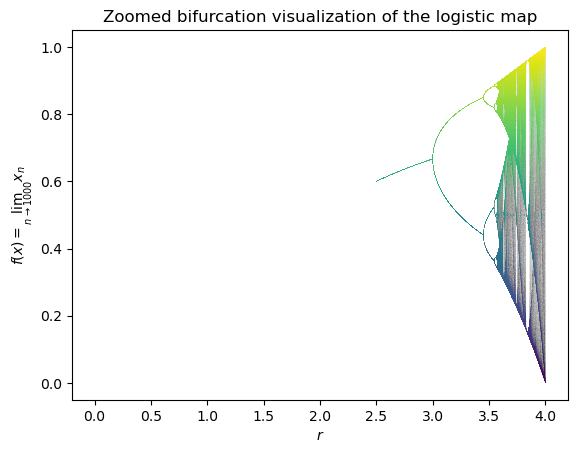

In [35]:
import matplotlib.cm as cm

# Normalisiere die y-Werte auf den Bereich [0, 1]
y_norm = (o.y - o.y.min()) / (o.y.max() - o.y.min())

# Wähle eine colormap
cmap = cm.viridis

# Erstelle das Diagramm
plt.scatter(o.r, o.y, s=0.1, alpha=0.01, edgecolors="None", color=cmap(y_norm))
plt.xlabel(r"$r$")
plt.ylabel(r"$f(x) = \lim_{n\rightarrow 1000} x_n$")
plt.title("Bifurcation visualization of the logistic map")
plt.savefig("bifurcation_logistic_large.png", dpi=900)
plt.savefig("bifurcation_logistic_large.pdf")
plt.show()

o_zoom = o[o.r > 2.5]

# Normalisiere die y-Werte auf den Bereich [0, 1]
y_norm = (o_zoom.y - o_zoom.y.min()) / (o_zoom.y.max() - o_zoom.y.min())

# Wähle eine colormap
cmap = cm.viridis

# Erstelle das Diagramm
plt.scatter(o_zoom.r, o_zoom.y, s=0.1, alpha=0.02, edgecolors="None", color=cmap(y_norm))
plt.xlabel(r"$r$")
plt.ylabel(r"$f(x) = \lim_{n\rightarrow 1000} x_n$")
plt.title("Zoomed bifurcation visualization of the logistic map")
plt.savefig("bifurcation_logistic_large_zoom.png", dpi=900)
plt.savefig("bifurcation_logistic_large_zoom.pdf")
plt.show()

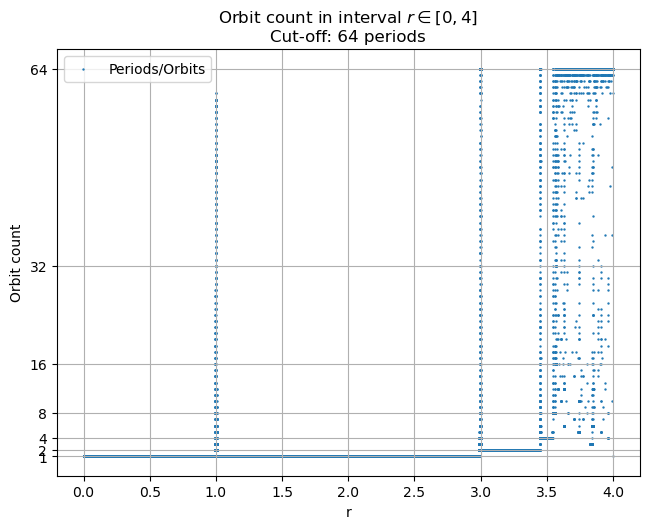

In [30]:
# Sort out duplicates in r and orbits, since they're no longer needed for the following evaluations
o = o.drop_duplicates(subset=['r', 'orbits'])

plt.scatter(o.r, o.orbits, s=0.5, label="Periods/Orbits")
plt.grid(True, which='both')
ticks = np.power(2, np.arange(0, 7))
plt.yticks(ticks)  # Setzt die y-Ticks auf Potenzen von 2 von 2^0 bis 2^7 (also bis 128)
plt.tight_layout()
plt.xlabel(r"$r$")
plt.ylabel("Orbit count")
plt.title(r"Orbit count in interval $r \in [0, 4]$" + "\nCut-off: 64 periods")
plt.legend()
plt.savefig("orbits_large.pdf")

o.to_csv('orbits.csv', index=False)

In [31]:
bifurcations = [0]
# for p in range(2, 7):
#     if 2**p != 4:
#         filtered_df = o.where(o['orbits'] == 2**p).dropna()
#     else:
#         filtered_df = o.where((o['orbits'] == 2**p) & (o['r'] > 3.2)).dropna()

#     if len(filtered_df) >= 2:
#         index = filtered_df.index[3]
#         r_value = o.loc[index, 'r']
#         bifurcations.append(r_value)
#         print(f"{3}. occurence for orbit count {2**p}: {r_value}")
#     else:
#         print(f"Es gibt weniger als 2 Elemente mit Orbits == {2**p}.")
#     print()

# Add points by hand because the data has too much noise
bifurcations.append(3)   # Transition to 2-periodic
bifurcations.append(3.451186279656991)  # 4
bifurcations.append(3.5440886022150555)   # 8
bifurcations.append(3.5644891122278057)   # 16   
bifurcations.append(3.5686892172304305)   # 32   
bifurcations.append(3.5695892397309934)   # 64   

print(f"Bifurcations: {bifurcations}")

lengths = []
for i in range(0, len(bifurcations) - 1):
    lengths.append(bifurcations[i+1] - bifurcations[i])
print(f"Lengths: {lengths}")

Feigenbaum = []  
for i in range(len(lengths) - 1):
    Feigenbaum.append(lengths[i] / lengths[i+1])
print(f"Feigenbaum: {Feigenbaum}")

for x in np.linspace(0.01, 1, 10, False):
    print(x)

Bifurcations: [0, 3, 3.451186279656991, 3.5440886022150555, 3.5644891122278057, 3.5686892172304305, 3.5695892397309934]
Lengths: [3, 0.4511862796569912, 0.0929023225580643, 0.020400510012750228, 0.004200105002624799, 0.0009000225005628693]
Feigenbaum: [6.649138360946421, 4.856566200215265, 4.553921568627488, 4.8571428571431445, 4.666666666664528]
0.01
0.109
0.20800000000000002
0.30700000000000005
0.406
0.505
0.6040000000000001
0.7030000000000001
0.802
0.901
